# Correspondence Autoencoder RNN for Speech

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [14]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
)

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12045
E.g. item shape: (61, 39)


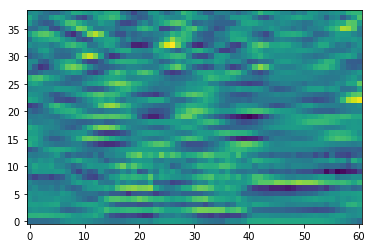

In [6]:
plt.imshow(train_x[3277].T, origin="bottom");

In [10]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2732
E.g. item shape: (61, 39)


In [11]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

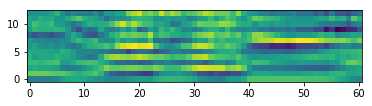

In [9]:
plt.imshow(train_x[3277].T, origin="bottom");

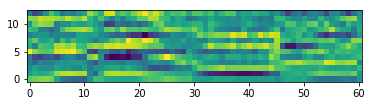

In [13]:
plt.imshow(val_x[0].T, origin="bottom");